In [1]:
from Model.transformer import save_model,SpatialTransformer,CustomDataset,load_model,relative_l2_loss
import torch
from torch.utils.data import Dataset, DataLoader

## load_model

In [2]:
model = SpatialTransformer()

/root/miniconda3/envs/app_math/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
data = torch.load("/root/NC_Dataset/2d/dam2d/trimask.pth")[:, :, 0, :, :]
dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)

In [13]:
import numpy as np 
data_slice = np.where(data == 0, np.nan, data)  # Replace zeros with NaN

In [5]:
model = load_model(model, load_path="/root/POFzhaoyang/Checkpoints/Triangle/tri_model_epoch_999.pth", device="cuda:0")

Model loaded from /root/POFzhaoyang/Checkpoints/Triangle/tri_model_epoch_999.pth, starting from epoch 999


In [6]:
import torch

# 假设你已经有一个加载好的模型变量名为model
# 你可以通过下面的代码统计模型的总参数量

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 计算参数量
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 9989376


In [10]:
data.shape

torch.Size([40, 31, 128, 128])

In [14]:
output  = model(data[:,0:1,:,:])

In [15]:
relative_l2_loss(output,data[:,1:31,:,:])

tensor(0.0770, grad_fn=<DivBackward0>)

In [88]:
output = output.detach().cpu().numpy()

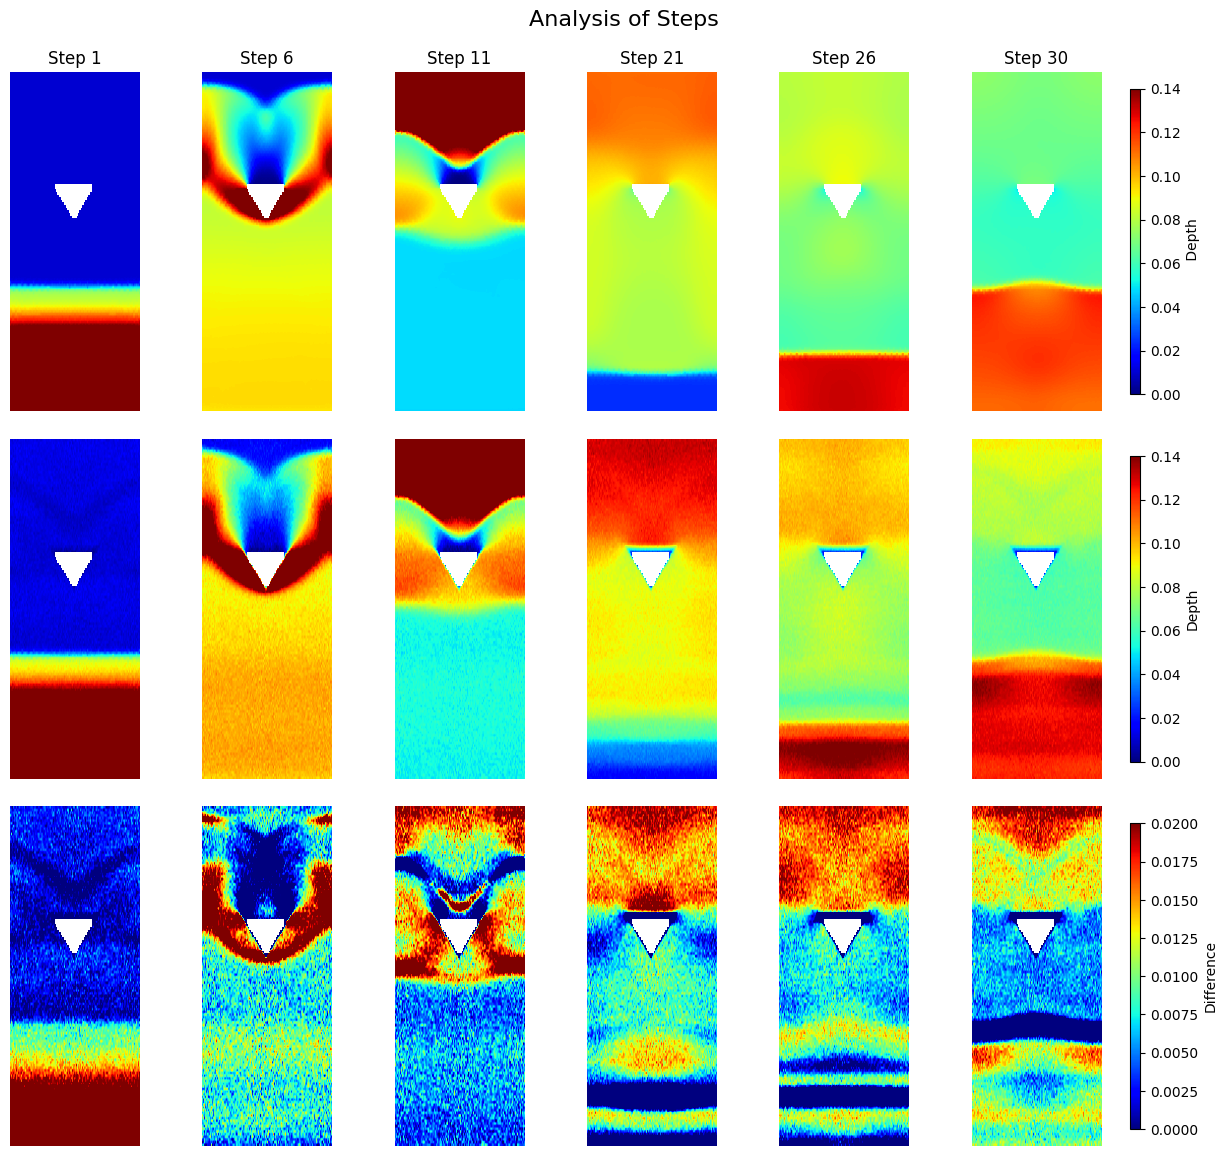

In [84]:
import matplotlib.pyplot as plt

# Assuming 'data_slice' is your ground truth and 'output' is your prediction,
# and both are four-dimensional arrays with shape [num_cases, num_steps, height, width]
# Here we select the 15th case, 2nd channel (Python indexing starts at 0)

steps = [0, 5, 10, 20, 25, 29]  # Actual steps corresponding to the indices

fig, axes = plt.subplots(3, len(steps), figsize=(15, 12))  # Create a grid of 3 rows and len(steps) columns
fig.suptitle('Analysis of Steps', fontsize=16, y=0.97)
pred =  output+ data_slice[:,1:31,:,:]
difference = pred - data_slice[:,1:31,:,:]
for i, step in enumerate(steps):
    # Ground truth
    im0 = axes[0, i].imshow(data_slice[0, step+1, :, :], extent=(0, 0.61, 0, 1.6), origin='lower', cmap='jet',vmin=0,vmax=0.14)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Step {step + 1}")

    # Prediction
    
    im1 = axes[1, i].imshow(pred[0, step, :, :], extent=(0, 0.61, 0, 1.6), origin='lower', cmap='jet',vmin=0,vmax=0.14)
    axes[1, i].axis('off')

    # Difference
    im2 = axes[2, i].imshow(difference[0, step, :, :], extent=(0, 0.61, 0, 1.6), origin='lower', cmap='jet',vmin=0,vmax=0.02)
    axes[2, i].axis('off')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.tight_layout(pad=2)

# Add a color bar to each row
cbar0 = fig.colorbar(im0, ax=axes[0, :].ravel().tolist(), orientation='vertical', pad=0.02, aspect=30, shrink=0.9)
cbar0.set_label(' Depth')
cbar1 = fig.colorbar(im1, ax=axes[1, :].ravel().tolist(), orientation='vertical', pad=0.02, aspect=30, shrink=0.9)
cbar1.set_label('Depth')
cbar2 = fig.colorbar(im2, ax=axes[2, :].ravel().tolist(), orientation='vertical', pad=0.02, aspect=30, shrink=0.9)
cbar2.set_label('Difference')

# Save the image with tight layout adjustments
plt.savefig("Compare_cir.png", dpi=300, bbox_inches='tight')


In [74]:
transformer_encoder = model.transformer_encoder